In [1]:
from external.pyFIS import pyFIS
import logging
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import numpy as np

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Get data

In [3]:
# Connect to FIS
FIS = pyFIS()

In [4]:
# Create full export of FIS
# outputdir = Path(f'Export_{FIS.geogeneration}')
# outputdir.mkdir(exist_ok=True)
# FIS.export(outputdir / 'export.csv')

In [5]:
# List all geotypes
# FIS.list_geotypes()

In [7]:
# Get all section (=vaarwegvakken) and sectionnodes
section = FIS.list_objects('section').set_index('Id') 
maximumdimensions = FIS.list_objects('maximumdimensions').set_index('Id')
navigability = FIS.list_objects('navigability').set_index('Id')

maximumdimensions_columns = ['GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
       'SeaFairingDepth', 'PushedLength',
       'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
       'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
       'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
       'SeaFairingHeight']

navigability_columns = ['Classification', 'Code', 'Description']

section = section.join(maximumdimensions[maximumdimensions_columns], rsuffix='maximumdimensions').join(navigability[navigability_columns], rsuffix='navigability')

In [8]:
# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

In [9]:
section_node = FIS.list_objects('sectionjunction').set_index('Id')

In [10]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

# Get all locks including chambesr
locks = FIS.merge_geotypes('lock', 'chamber')

In [11]:
# Draw polygon on http://geojson.io
extend_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              5.204772949218749,
              51.742336876891024
            ],
            [
              6.2347412109375,
              51.742336876891024
            ],
            [
              6.2347412109375,
              51.945957916403266
            ],
            [
              5.204772949218749,
              51.945957916403266
            ],
            [
              5.204772949218749,
              51.742336876891024
            ]
          ]
        ]
      }
    }
  ]
}

In [56]:
# Create selection for processing
extend_polygon = Polygon(extend_geojson['features'][0]['geometry']['coordinates'][0])
section_selection = section[section.geometry.within(extend_polygon)]
bridges_selection = bridges[bridges.geometry.within(extend_polygon)]
locks_selection = locks[locks.geometry.within(extend_polygon)]

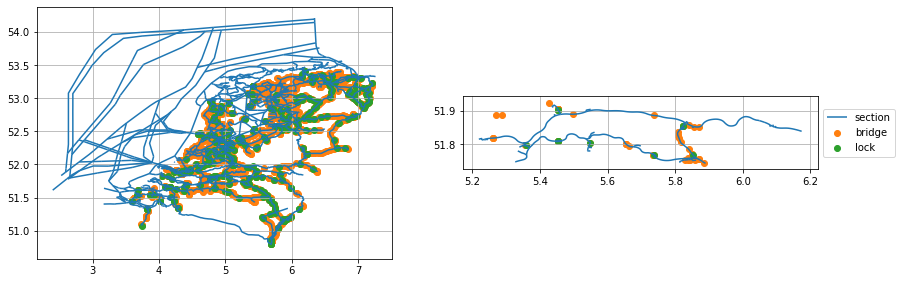

In [57]:
f, ax  = plt.subplots(figsize=(14,10), ncols=2)
section.plot(color='C0', ax=ax[0])
bridges.plot(c='C1', ax=ax[0])
locks.plot(c='C2', ax=ax[0])
ax[0].grid()

section_selection.plot(color='C0', ax=ax[1], label='section')
bridges_selection.plot(c='C1', ax=ax[1], label='bridge')
locks_selection.plot(c='C2', ax=ax[1], label='lock')
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Build network

In [64]:
section_selection['length'] = section_selection.length.values
network = nx.from_pandas_edgelist(section_selection, 'StartJunctionId', 'EndJunctionId', edge_attr=True)

In [65]:
# Add node properties
for n in network.nodes:
    network.node[n]['X'] = section_node.loc[n].geometry.x
    network.node[n]['Y'] = section_node.loc[n].geometry.y

(5.167218224988949, 6.22633258853889, 51.72882103141142, 51.93124393196467)

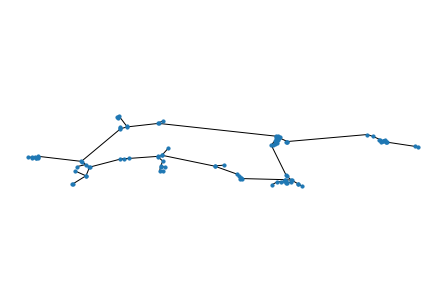

In [66]:
nx.draw(network, 
        pos={k: (v['X'], v['Y']) for k, v in network.node.items()}, 
        node_size=10)
plt.gca().axis('equal')

# Now add bridges as nodes

I'm not sure if this was really necessary...

In [58]:
# Splitting the closest line at given point

def nearest_line(point, lines):
    # Returns index of the closest line to the point
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    return np.argmin(d), np.min(d)

def chainage_on_line(point, line):
    # Find chainage of line closest to point
    return line.project(point)
    
def cut(line, chainage):
    # Cuts a line in two at a distance from its starting point
    if chainage <= 0.0 or chainage >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == chainage:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > chainage:
            cp = line.interpolate(chainage)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]


# Example data
# ls1 = LineString([(0,0), (4,4), (5,2)])
# ls2 = LineString([(0,0), (4, 0), (6,1)])
# ls = [ls1, ls2]
# p = Point(2,3)
# 
# ii, distance = nearest_line(p, ls)
# c = chainage_on_line(p, ls[ii])
# split = cut(ls[ii], c)

In [59]:
# Remove nans
bridges_selection = bridges_selection[~bridges_selection['HeightClosed'].isna()]

# Only keep opening with the maximum HeightClosed
id_max_height = bridges_selection.groupby('Id')['HeightClosed'].idxmax()
bridges_selection = bridges_selection.reindex(id_max_height.values)
bridges_selection = bridges_selection.set_index('Id')

In [60]:
section_selection_with_bridges = section_selection.copy()
for k, bridge in bridges_selection.iterrows():
    
    # abreviate
    b = bridge.geometry
    s = section_selection_with_bridges.geometry.values
    
    # Split closest section
    nearest_section, distance_to_nearest_section = nearest_line(b, s)
    if distance_to_nearest_section> 0.01: # If distance it too large, apparently it's not near a section
        print(f'{bridge.Name}: Too far')
        continue
    elif distance_to_nearest_section == 0:
        print(f'{bridge.Name}: On top of branch, not yet implemented')
        continue
    else:
        pass

    chainage = chainage_on_line(b, s[nearest_section])
    split = cut(s[nearest_section], chainage)

    
    # Create new sections    
    section_old = section_selection_with_bridges.iloc[nearest_section]

    section_new_1 = section_old.copy()
    section_new_2 = section_old.copy()

    section_new_1['geometry'] = split[0]
    section_new_2['geometry'] = split[1]

    bridge_ID = f'B{k}'

    section_new_1['EndJunctionId'] = bridge_ID
    section_new_2['StartJunctionId'] = bridge_ID
    
    section_new_1.name = f'{section_old}_A'
    section_new_2.name = f'{section_old}_B'
    
    # Update DataFrame
    section_selection_with_bridges = section_selection_with_bridges.drop(section_old.name, axis='index')
    section_selection_with_bridges = section_selection_with_bridges.append(section_new_1)
    section_selection_with_bridges = section_selection_with_bridges.append(section_new_2)

Rooijensteinsebrug: Too far
Hardwegbrug: On top of branch, not yet implemented
Keersluisbrug (1): On top of branch, not yet implemented
spoorbrug Geldermalsen: Too far
Geldermalsen, brug in de N-833: Too far


In [52]:
section_selection_with_bridges['length'] = section_selection_with_bridges.length.values
network = nx.from_pandas_edgelist(section_selection_with_bridges, 'StartJunctionId', 'EndJunctionId', edge_attr=True)

In [53]:
# Add node properties
for n in network.nodes:
    if isinstance(n, str) and n[0] == 'B':
        bridge = bridges_selection.loc[int(n[1:])].geometry
        network.node[n]['X'] = bridge.x
        network.node[n]['Y'] = bridge.y
    else:
        node = section_node.loc[n].geometry
        network.node[n]['X'] = node.x
        network.node[n]['Y'] = node.y

(5.166049372359183, 6.2275014411686564, 51.7268613325763, 51.933203630799795)

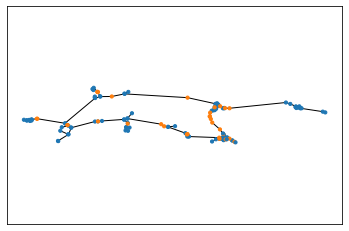

In [54]:
nx.draw_networkx(network, 
        pos={k: (v['X'], v['Y']) for k, v in network.node.items()}, 
        node_color=['C1' if isinstance(k, str) else 'C0' for k in network.node],
                 with_labels =False,
        node_size=10)
plt.gca().axis('equal')